![img](https://s1.postimg.org/6fl45xnvnj/pytorch-logo-dark.png)

In [1]:
% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

На этом занятии помимо базового функционала `pytorch` будет использоваться библиотека для зрения **`torchvision`**.

## Еще немного про переменные и тензоры

In [2]:
import torch
from torch.autograd import Variable

Уже со следующей версии 0.4 механика tensor <-> Variable станет прозрачной и Variable как отдельной сущности больше не будет.

![img](https://cs8.pikabu.ru/post_img/2016/10/22/3/1477104625110531972.jpg)

А пока стоит знать про особый режим у Variable — **`volatile`** в дополнение к **`requires_grad`**.

**`volatile`** используется в случае чистого инференса модели, механика наследования флага отличается от **`requires_grad`**:

In [3]:
from torchvision import models

regular_input = Variable(torch.randn(1, 3, 224, 224))
volatile_input = Variable(torch.randn(1, 3, 224, 224), volatile=True)
model = models.resnet18(pretrained=False)

In [4]:
model(regular_input).requires_grad

True

In [5]:
model(volatile_input).requires_grad

False

In [6]:
model(volatile_input).volatile

True

In [7]:
model(volatile_input).grad_fn is None

True

Главное отличие:
* Переменная с флагом **`requires_grad=False`** останавливает обратное распространение ошибки.
* Переменная с флагом **`volatile=True`** полностью выключает backprop для нее самой и всего, зависящего от нее.

По умолчанию соответственно наоборот — **`requires_grad=True`** и **`volatile=False`**.

Где-то во время обучения:

    images = Variable(images).cuda()
    targets = Variable(targets).cuda(async=True)
   
Где-то еще во время валидации/предсказания:

    images = Variable(images, volatile=True).cuda()
    targets = Variable(targets, volatile=True).cuda(async=True)

# Pytorch как конструктор

## Работа с датасетами

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Кастомный пример — датасет, загружающий изображения на основе путей и классов из текстового файла:

In [8]:
from torch.utils.data import Dataset
# default_loader - стандартная функция для загрузки изображений, использует accimage или PIL
from torchvision.datasets.folder import default_loader

class TxtList(Dataset):
    def __init__(self, path, transform=None, loader=default_loader):
        with open(path) as fin:
            self.imgs = [s.strip().split() for s in fin.readlines()]

        print(f'=> Found {len(self.imgs)} entries in {path}')

        self.classes = sorted(set([_[1] for _ in self.imgs]))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path, target = self.imgs[index]
        target = self.class_to_idx[target]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
!echo '/tmp/1.jpg\tcat' > /tmp/dataset.tsv
!echo '/tmp/2.jpg\tcat' >> /tmp/dataset.tsv
!echo '/tmp/3.jpg\tdog' >> /tmp/dataset.tsv
!echo '/tmp/4.jpg\tcat' >> /tmp/dataset.tsv

In [10]:
catdog = TxtList('/tmp/dataset.tsv')

=> Found 4 entries in /tmp/dataset.tsv


In [11]:
catdog.classes

['cat', 'dog']

In [12]:
catdog.imgs

[['/tmp/1.jpg', 'cat'],
 ['/tmp/2.jpg', 'cat'],
 ['/tmp/3.jpg', 'dog'],
 ['/tmp/4.jpg', 'cat']]

In [13]:
len(catdog)

4

In [14]:
# FileNotFoundError
# catdog[0]

`torchvision` также содержит и другие готовые классы для стандартных датасетов: 
http://pytorch.org/docs/master/torchvision/datasets.html.

Некоторые из них можно сразу и загрузить — например, **MNIST**:

In [15]:
# !rm -r '/tmp/mnist/' 2>/dev/null

In [16]:
from torchvision.datasets import MNIST

%time mnist = MNIST('/tmp/mnist/', train=True, download=True)

CPU times: user 6.81 ms, sys: 20.5 ms, total: 27.3 ms
Wall time: 28.9 ms


In [17]:
len(mnist)

60000

In [18]:
image, target = mnist[0]
print(target)

5


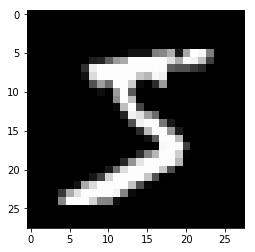

In [19]:
plt.imshow(np.array(image), 'gray')
plt.show()

## <font color='#cc6666'>Внимание, задача!</font>

Релизуйте ниже датасет **`UrlList`**, конструктор которого на вход принимает список ссылок на изображения.

In [20]:
class UrlList(Dataset):
    pass

Покажите его работу на примере:

In [21]:
pass

## Преобразования данных

Конструктор примера, приведенного выше, также как и стандартного `ImageFolder`, принимают параметр `transform` (и `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований:

In [22]:
from torchvision import transforms

Например, `transforms.ToTensor()` преобразует `PIL`-изображение типа uint8 с доменом [0, 256) в тензор с доменом [0, 1].

In [23]:
to_tensor = transforms.ToTensor()

In [24]:
pil_image = mnist[0][0]
th_image = to_tensor(pil_image)
th_image.shape, th_image.min(), th_image.max()

(torch.Size([1, 28, 28]), 0.0, 1.0)

А для того, чтобы нормализовывать изображения из ImageNet'а по стандартной схеме, можно объявить

In [25]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Для объединения нескольких преобразваний в одно есть `Compose`:

In [26]:
crop_and_tensorize = transforms.Compose([
    transforms.CenterCrop(16),
    transforms.ToTensor(),
])

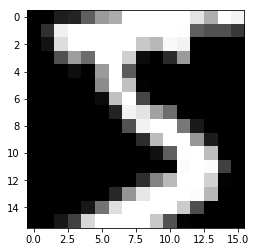

In [27]:
plt.imshow(crop_and_tensorize(pil_image)[0].numpy(), 'gray')
plt.show()

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.

## <font color='#cc6666'>Внимание, задача!</font>

Реализуйте класс-трансформер, осуществляющий с подаваемым на вход изображением случайное преобразование из группы диэдра $D_4$.

In [28]:
class RandomD4(object):
    def __call__(self, img):
        pass

Покажите его работу на примере из MNIST:

In [29]:
pass

## Загрузчики данных

Основная магия, для которой и нужны датасеты в приведенном выше виде, это загрузчики:

In [30]:
from torch.utils.data import DataLoader

Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

При этом батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах!

Рассмотрим их на примере с MNIST, при этом добавим к нему трансформер, т.к. лоадеры работают с тензорами или скалярами, но не `PIL.Image`.

In [31]:
transformed_mnist = MNIST('/tmp/mnist/', train=True, transform=transforms.ToTensor())

In [32]:
mnist_loader = DataLoader(transformed_mnist, batch_size=16, shuffle=True, num_workers=4)

Стандартные параметры приведены выше. При добавлении **`pin_memory=True`** батчи еще и сразу раскладываются по видеокартам.

Посмотрим на работу в деле:

In [33]:
for images, targets in tqdm(mnist_loader):
    pass

100%|██████████| 3750/3750 [00:05<00:00, 746.33it/s]


На выходе из лоадера получаем батчи:

In [34]:
images.shape

torch.Size([16, 1, 28, 28])

In [35]:
targets.shape

torch.Size([16])

Количество батчей заранее известно (чему был рад `tqdm`):

In [36]:
len(mnist_loader)

3750

Пример данных (при каждом повторении прохода по мнисту пример будет случайным):

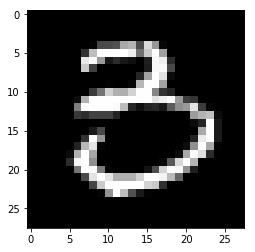

In [37]:
plt.imshow(images[0][0].numpy(), 'gray')
plt.show()

In [38]:
print(targets[0])

3


## Создание моделей

Для создания моделей наследуемся от `torch.nn.Module`, `torch.nn` также содержит стандартные "кирпичики" моделей.

Функциональные версии кирпичей скрыты в `torch.nn.functional`.

In [39]:
import torch.nn as nn
import torch.nn.functional as F

Для макспулинга, активаций, апсемплинга и некоторых других операций есть как "модульные", так и "функциональные" версии:
* `nn.MaxPool2d` <-> `F.max_pool2d`
* `nn.ReLU` <-> `F.relu`
* `nn.Upsample(mode='bilinar')` <-> `F.upsample(mode='bilinar')`

При использовании модульных версий слоев во время создания простой модели можно обходиться `nn.Sequential` для их "склейки":

In [40]:
layers = [
    nn.Conv2d(3, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1),
    nn.ReLU()
]
unet_down1 = nn.Sequential(*layers)
print(unet_down1)

Sequential(
  (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
)


## Обучение моделей

Для обучения моделей необходимо определить функцию потерь, их примеры содержатся все в том же модуле `torch.nn`:

```python
output = model(torch.cat(x, 1))
target = Variable(torch.arange(1, 1001))
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)
```

Веса обновлять можно как вручную (или воспользоваться реализованным ранее оптимизатором):

```python
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)
```

Так и пользоваться стандартным оптимизатором из модуля `torch.optim`:
```python
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01)
```

Для зануления градиентов теперь можно обращаться к оптимизатору:
```python
optimizer.zero_grad()
```

Инференс, подсчет ошибки и бэкпроп делаем как раньше:
```python
output = net(x)
loss = criterion(output, target)
loss.backward()
```

А для обновления весов используем оптимизатор:
```python
optimizer.step()
```

Для работы с шагом обучения в **`optim`** есть подмодуль **`torch.optim.lr_scheduler`**:
```python
from torch.optim import lr_scheduler
```

Например, обучение ResNet на ImageNet по стандартной схеме будет работать примерно так:
```python
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
for epoch in range(100):
     scheduler.step()
     # train(...)
     # validate(...)
```

# Pytorch в бою

## Создание модели сегментации на примере U-Net

![img](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [41]:
import torch
from torch import nn
from torch.autograd import Variable

Часто используемые свертки:

In [42]:
def conv3x3(in_channels, out_channels, dilation=1):
    return nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation)

Один **блок кодировщика** состоит из двух последовательных сверток, активаций и опционального батчнорма:

In [43]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.batch_norm = batch_norm

        self.conv1 = conv3x3(in_channels, out_channels)
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = conv3x3(out_channels, out_channels)
        if self.batch_norm:
            self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.relu2(x)
        return x

In [44]:
block = EncoderBlock(3, 64)
block

EncoderBlock(
  (conv1): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
)

In [45]:
x = Variable(torch.zeros(4, 3, 128, 128), volatile=True)

block(x).shape

torch.Size([4, 64, 128, 128])

Альтернативное объявление:

In [46]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.block = nn.Sequential()
        self.block.add_module('conv1', conv3x3(in_channels, out_channels))
        if batch_norm:
            self.block.add_module('bn1', nn.BatchNorm2d(out_channels))
        self.block.add_module('relu1', nn.ReLU())
        self.block.add_module('conv2', conv3x3(out_channels, out_channels))
        if batch_norm:
            self.block.add_module('bn2', nn.BatchNorm2d(out_channels))
        self.block.add_module('relu2', nn.ReLU())

    def forward(self, x):
        return self.block(x)

In [47]:
block = EncoderBlock(3, 64)
block

EncoderBlock(
  (block): Sequential(
    (conv1): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
)

In [48]:
x = Variable(torch.zeros(4, 3, 128, 128), volatile=True)

block(x).shape

torch.Size([4, 64, 128, 128])

И "функциональная версия":

In [49]:
def encoder_block(in_channels, out_channels, batch_norm=False):
    block = nn.Sequential()
    block.add_module('conv1', conv3x3(in_channels, out_channels))
    if batch_norm:
        block.add_module('bn1', nn.BatchNorm2d(out_channels))
    block.add_module('relu1', nn.ReLU())
    block.add_module('conv2', conv3x3(out_channels, out_channels))
    if batch_norm:
        block.add_module('bn2', nn.BatchNorm2d(out_channels))
    block.add_module('relu2', nn.ReLU())
    return block

In [50]:
block = encoder_block(3, 64)
block

Sequential(
  (conv1): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
)

In [51]:
x = Variable(torch.zeros(4, 3, 128, 128), volatile=True)

block(x).shape

torch.Size([4, 64, 128, 128])

Кодировщик в целом состоит из таких блоков.

Его конструкция определяется входными каналами, количеством фильтров в первом блоке и количеством блоков.

Помним также, что для работы сети нам нужно запоминать промежуточные активации.

In [52]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_filters, num_blocks):
        super().__init__()

        self.num_blocks = num_blocks
        for i in range(num_blocks):
            in_channels = in_channels if not i else num_filters * 2 ** (i - 1)
            out_channels = num_filters * 2**i
            self.add_module(f'block{i + 1}', encoder_block(in_channels, out_channels))
            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f'block{i + 1}')(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f'pool{i + 1}')(x)
        return acts

Здесь как раз помогает подход к построению через с **`add_module`**, т.к. их количество переменно.

In [53]:
encoder = Encoder(in_channels=3, num_filters=8, num_blocks=4)
encoder

Encoder(
  (block1): Sequential(
    (conv1): Conv2d (3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d (8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (block2): Sequential(
    (conv1): Conv2d (8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d (16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (block3): Sequential(
    (conv1): Conv2d (16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (block4): Sequential(
    (conv1): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), paddi

In [54]:
x = Variable(torch.zeros(4, 3, 512, 512), volatile=True)

[_.shape for _ in encoder(x)]

[torch.Size([4, 8, 512, 512]),
 torch.Size([4, 16, 256, 256]),
 torch.Size([4, 32, 128, 128]),
 torch.Size([4, 64, 64, 64])]

Блок декодировщика состоит из апскейлинга входа "снизу", объединения двух входов и сверток как в кодировщике:

In [55]:
class DecoderBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.uppool = nn.Upsample(scale_factor=2, mode='bilinear')
        self.upconv = conv3x3(out_channels * 2, out_channels)
        self.conv1 = conv3x3(out_channels * 2, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)

    def forward(self, down, left):
        x = self.uppool(down)
        x = self.upconv(x)
        x = torch.cat([left, x], 1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [56]:
block = DecoderBlock(8)

In [57]:
y = encoder(x)

In [58]:
y[1].shape, y[0].shape

(torch.Size([4, 16, 256, 256]), torch.Size([4, 8, 512, 512]))

In [59]:
block(y[1], y[0]).shape

torch.Size([4, 8, 512, 512])

Декодировщик собираем из таких блоков:

In [60]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [61]:
decoder = Decoder(8, 3)

In [62]:
x.shape

torch.Size([4, 3, 512, 512])

In [63]:
[_.shape for _ in encoder(x)]

[torch.Size([4, 8, 512, 512]),
 torch.Size([4, 16, 256, 256]),
 torch.Size([4, 32, 128, 128]),
 torch.Size([4, 64, 64, 64])]

In [64]:
decoder(encoder(x)).shape

torch.Size([4, 8, 512, 512])

U-Net состоит из такого кодировщика и декодировщика, а также финального слоя классификации:

In [65]:
class UNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, num_filters=64, num_blocks=4):
        super().__init__()

        print(f'=> Building {num_blocks}-blocks {num_filters}-filter U-Net')

        self.encoder = Encoder(in_channels, num_filters, num_blocks)
        self.decoder = Decoder(num_filters, num_blocks - 1)
        self.final = nn.Conv2d(num_filters, num_classes, 1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

"Интеграционное тестирование":

In [66]:
model = UNet(num_classes=1)
if torch.cuda.is_available():
    model.cuda()

images = Variable(torch.randn(4, 3, 416, 416), volatile=True)
if torch.cuda.is_available():
    images = images.cuda()

model.forward(images).shape

=> Building 4-blocks 64-filter U-Net


torch.Size([4, 1, 416, 416])

На выходе получаем бинарную маску из линейных активаций.

Для обучения такой модели используются функции потерь с **WithLogits** в названии.

В вероятности их можно превращать с помощью `torch.nn.functional.sigmoid`

## Использование готового кодировщика

Структура блоков кодировщика рассмотренной только что сети сильно походит на таковую в сетях VGG:

![img](https://www.pyimagesearch.com/wp-content/uploads/2017/03/imagenet_vgg16.png)

Посмотрим на неё же из недр `torchvision`:

In [67]:
from torchvision.models import vgg13

VGG13 - версия сети с 2 сверткаим на каждый блок:

In [68]:
model = vgg13()

In [69]:
model

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (15): Conv2d (256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU(inplace)
    (17): Conv2d (512, 512, kernel_size=(3, 3), 

Классификатор нам не нужен, интересуют только признаки.

Они в свою очередь делятся на блоки conv-relu-conv-relu + maxpooling.

Реализуем кодировщик на основе вычленения нужных блоков:

In [70]:
class VGG13Encoder(nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()

        backbone = vgg13(pretrained=pretrained).features

        self.num_blocks = num_blocks
        for i in range(self.num_blocks):
            block = nn.Sequential(*[backbone[j] for j in range(i * 5, i * 5 + 4)])
            self.add_module(f'block{i + 1}', block)
            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = []
        for i in range(self.num_blocks):
            x = self.__getattr__(f'block{i + 1}')(x)
            acts.append(x)
            if i != self.num_blocks - 1:
                x = self.__getattr__(f'pool{i + 1}')(x)
        return acts

In [71]:
vgg_encoder = VGG13Encoder(num_blocks=4)
vgg_encoder

VGG13Encoder(
  (block1): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (block2): Sequential(
    (0): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (block3): Sequential(
    (0): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
  )
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (block4): Sequential(
    (0): Conv2d (256, 512, kernel_size=(3, 3), stride=(1, 1

Сравним с "ванильным" кодировщиком:

In [72]:
encoder = Encoder(in_channels=3, num_filters=64, num_blocks=4)
encoder

Encoder(
  (block1): Sequential(
    (conv1): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (block2): Sequential(
    (conv1): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (block3): Sequential(
    (conv1): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (block4): Sequential(
    (conv1): Conv2d (256, 512, kernel_size=(3, 3), stride=

Получили идентичную структуру!

Только теперь у нас уже есть предобученные слои для выделения признаков в кодировщике.

## <font color='#cc6666'>Внимание, задача!</font>


**Реализуйте датасет** для игрушечной задачи сегментации, реализующий такие данные:

![img](https://raw.githubusercontent.com/jakeret/tf_unet/master/docs/toy_problem.png)

Т.е. необходимо генерировать цветные эллипсы на цветном фоне и к итоговой картинке добавлять шум разной природы.

При этом датасет выдает как изображение, так и его бинарную маску.

In [73]:
class Ellipses(Dataset):
    pass

Для решения этой задачи **реализуйте сеть LinkNet** на основе кодировщика двух предобученных сетей `torchvision` из разных семейств (не VGG).

В качестве лосса рекомендуется использовать `BCEWithLogitsLoss`.

In [74]:
class LinkNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, num_filters=64, num_blocks=4):
        pass

    def forward(self, x):
        pass

**Проиллюстрируйте процесс обучения** сети скриншотами из `tensorboard` (см. `lanpa/tensorboard-pytorch`).

Необходимо в частности отобразить кривую обучения и примеры эволюции качества выдаваемых масок.